# 1. Upload Dataset to Kaggle

In [1]:
import os

input_dir = '/kaggle/input/fetal-head-biometry-in-ultrasound-images'
print("Files in the directory:", os.listdir(input_dir))


Files in the directory: ['MyFolder']


In [2]:
folder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images'
print("Files in folder:", os.listdir(folder_path))


Files in folder: ['MyFolder']


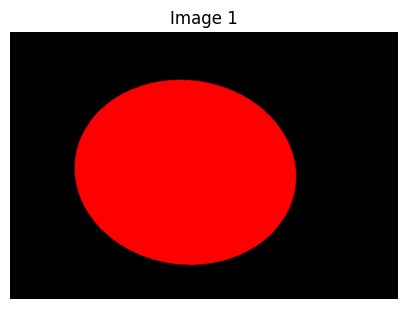

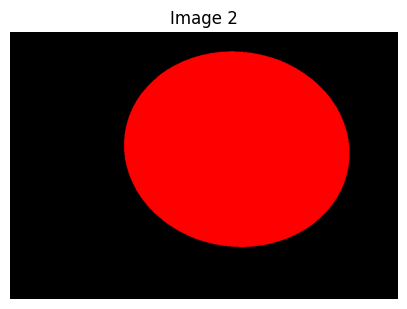

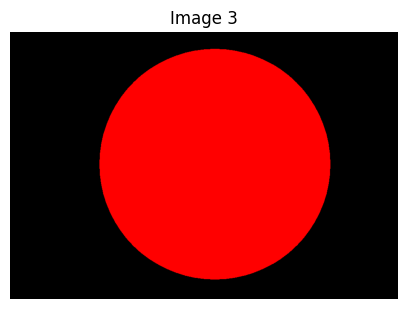

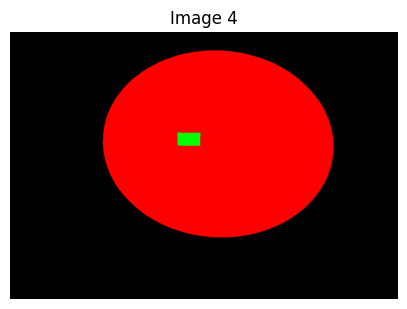

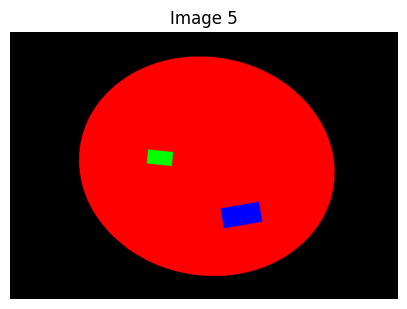

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the subfolder where your images are stored
subfolder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'

# List all PNG files in the specific subfolder
image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]

# Display the first 5 PNG images
for i, img_file in enumerate(image_files[:5]):
    img_path = os.path.join(subfolder_path, img_file)  # Construct full path
    img = Image.open(img_path)  # Open image using PIL
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Hide axis labels
    plt.show()


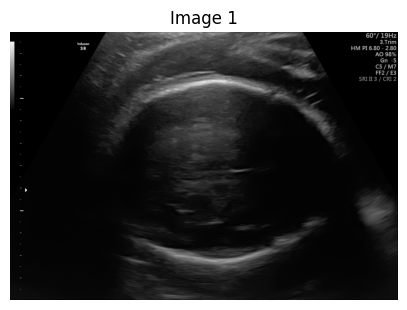

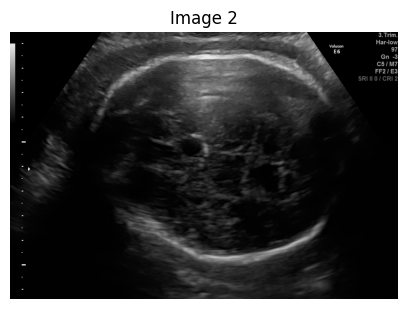

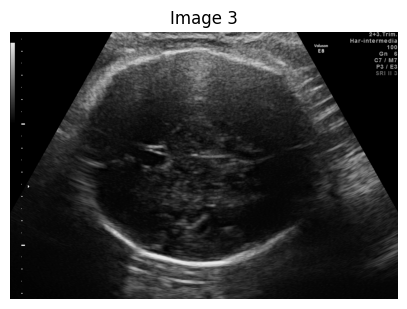

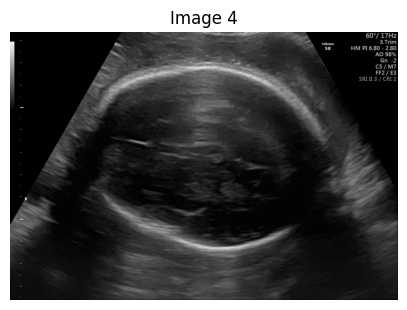

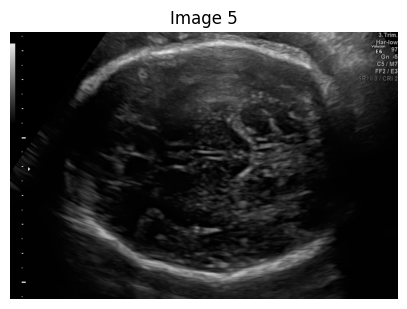

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the subfolder where your images are stored
subfolder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-orginal-size'

# List all PNG files in the specific subfolder
image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]

# Display the first 5 PNG images
for i, img_file in enumerate(image_files[:5]):
    img_path = os.path.join(subfolder_path, img_file)  # Construct full path
    img = Image.open(img_path)  # Open image using PIL
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Hide axis labels
    plt.show()


# 2. Import Libraries

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from scipy.stats import ttest_ind, ks_2samp
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 3. Define Paths

In [6]:
segmentation_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'
original_images_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-orginal-size'
output_train_test_csv = "/kaggle/working/Train_Test_comparison_metrics.csv"
output_validation_csv = "/kaggle/working/Train_Validation_comparison_metrics.csv"
output_best_hc_csv = "/kaggle/working/Final_Best_HC_values.csv"


# 4. Load Images

In [7]:
import os
import cv2

def load_images(folder_path):
    images = []  # List to store the images
    image_ids = []  # List to store the image filenames
    
    # Iterate over all the files in the specified folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with '.png'
        if file_name.endswith('.png'):
            # Construct the full path to the image file
            img_path = os.path.join(folder_path, file_name)
            # Read the image in grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Append the image and its ID to the respective lists
            images.append(image)
            image_ids.append(file_name)
    
    return images, image_ids


In [8]:
# Define the path to the folder where your images are stored
folder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'

# Load the images from the folder
images, image_ids = load_images(folder_path)

# Example: print the number of images and the first 5 image IDs
print(f"Loaded {len(images)} images.")
print(f"Image IDs: {image_ids[:5]}")  # Show the first 5 image IDs


Loaded 1575 images.
Image IDs: ['Patient00791_Plane3_2_of_3.png', 'Patient01483_Plane3_1_of_4.png', 'Patient01512_Plane3_1_of_2.png', 'Patient00767_Plane3_1_of_3.png', 'Patient01529_Plane3_2_of_3.png']


# 5. Preprocess Images

In [9]:
import cv2
import numpy as np

def preprocess_data(images, size=(256, 256)):  # Resize to near-original dimensions
    # Resize each image to the specified size (256, 256 by default)
    images_resized = [cv2.resize(image, size) for image in images]
    
    # Normalize the images to the range [0, 1]
    images_normalized = np.array(images_resized) / 255.0
    
    # Add an additional dimension to match the shape (height, width, channels)
    images_normalized = np.expand_dims(images_normalized, axis=-1)
    
    return images_normalized


In [10]:
# Assume you've loaded images using the load_images() function
folder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'
images, image_ids = load_images(folder_path)

# Preprocess the images
preprocessed_images = preprocess_data(images, size=(256, 256))

# Example: check the shape of the preprocessed images
print(f"Preprocessed images shape: {preprocessed_images.shape}")


Preprocessed images shape: (1575, 256, 256, 1)


# 6. Calculate Head Circumference(HC)

In [11]:
import cv2
import numpy as np

def calculate_head_circumference_dynamic(image, size=(256, 256), method="otsu"):
    """
    Calculate the head circumference using dynamic thresholding.

    Args:
        image (numpy.ndarray): Input segmentation image.
        size (tuple): Resize dimensions (width, height).
        method (str): Dynamic thresholding method: "otsu" or "adaptive".

    Returns:
        float: Circumference of the largest contour (in pixels), or None if no contours are found.
    """
    # Resize the image to the desired size
    resized_image = cv2.resize(image, size)

    # Apply the chosen thresholding method
    if method == "otsu":
        # Otsu's Thresholding
        _, binary_image = cv2.threshold(
            resized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    elif method == "adaptive":
        # Adaptive Thresholding
        binary_image = cv2.adaptiveThreshold(
            resized_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
    else:
        raise ValueError("Invalid method. Choose 'otsu' or 'adaptive'.")

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Calculate and return the circumference of the largest contour
        return cv2.arcLength(largest_contour, True)

    # Return None if no contours are found
    return None


In [12]:
# Define the path to the segmentation images (replace with your actual Kaggle dataset path)
folder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'

# Load a specific image (e.g., first image)
image_path = os.path.join(folder_path, 'Patient00168_Plane3_1_of_3.png')
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Calculate the head circumference
circumference = calculate_head_circumference_dynamic(image, size=(256, 256), method="otsu")

# Output the result
if circumference is not None:
    print(f"Head circumference: {circumference} pixels")
else:
    print("No contours found.")


Head circumference: 630.8843396902084 pixels


In [13]:
# Define the path to the segmentation images (replace with your actual Kaggle dataset path)
folder_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-orginal-size'

# Load a specific image (e.g., first image)
image_path = os.path.join(folder_path, 'Patient00168_Plane3_1_of_3.png')
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Calculate the head circumference
circumference = calculate_head_circumference_dynamic(image, size=(256, 256), method="otsu")

# Output the result
if circumference is not None:
    print(f"Head circumference: {circumference} pixels")
else:
    print("No contours found.")


Head circumference: 957.5777699947357 pixels


# 7. Build U-Net Model

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Step 7: Build U-Net Model
def build_unet(input_shape=(256, 256, 1)):  # Adjusted input size to (256, 256, 1)
    inputs = layers.Input(shape=input_shape)

    # Downsample (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsample (Expansive Path)
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

# Build and Compile U-Net
unet = build_unet(input_shape=(256, 256, 1))  # Use the new image size (256, 256)
unet.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Model Summary
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        131,200 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_8[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 256, 256, 64)   │         32,832 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d_9[0][0],        │
│ (Concatenate)        

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Train the Model

In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define paths for segmentation images
segmentation_path = '/kaggle/input/fetal-head-biometry-in-ultrasound-images/MyFolder/Trans-thalamic-Segmentation/SegmentationClass'

# Load images and preprocess them
segmentation_images, segmentation_ids = load_images(segmentation_path)
segmentation_images = preprocess_data(segmentation_images)  # Ensure all images are resized and normalized

# Split the dataset into training and testing sets
train_images, test_images, train_ids, test_ids = train_test_split(
    segmentation_images, segmentation_ids, test_size=0.2, random_state=42
)

# Data generators for training and validation
datagen = ImageDataGenerator()  # No rescaling here because images are already normalized in preprocess_data()

train_generator = datagen.flow(train_images, train_images, batch_size=2)
validation_generator = datagen.flow(test_images, test_images, batch_size=2)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the U-Net model
history = unet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=2,  # Adjust epochs as per your needs
    callbacks=[early_stopping]
)

# Save the model after training
unet.save('/kaggle/working/unet_model.h5')
print("Model saved at /kaggle/working/unet_model.h5")


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


630/630 ━━━━━━━━━━━━━━━━━━━━ 2826s 4s/step - accuracy: 0.6558 - loss: 0.2943 - val_accuracy: 0.6399 - val_loss: 0.2185
Epoch 2/2
630/630 ━━━━━━━━━━━━━━━━━━━━ 2812s 4s/step - accuracy: 0.6493 - loss: 0.2129 - val_accuracy: 0.6399 - val_loss: 0.2184
Model saved at /kaggle/working/unet_model.h5


# 9. Predict and Calculate HC

In [19]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from tensorflow.keras.models import load_model

# Function to calculate the head circumference (HC) from the binary mask
def calculate_head_circumference(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:  # If contours are found
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)  # Calculate perimeter (circumference)
        return perimeter
    return 0  # Return 0 if no contours are found

# Function to predict segmentation masks and calculate HC
def predict_and_calculate_hc(model, images, ids):
    results = []
    print("Calculating HC values...")
    for image, image_id in tqdm(zip(images, ids), total=len(ids)):
        # Predict the segmentation mask (binary mask)
        predicted_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0, :, :, 0]
        # Binarize the predicted mask
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
        # Calculate head circumference (HC)
        hc = calculate_head_circumference(predicted_mask * 255)  # Multiply by 255 to ensure it's a proper binary mask
        results.append({"Image_ID": image_id, "HC_Value": hc})
    return pd.DataFrame(results)

# Assuming the U-Net model has been trained and saved, load the model
unet = load_model('/kaggle/working/unet_model.h5')  # Replace with actual model path

# Predict and calculate HC for training and test data
train_results_df = predict_and_calculate_hc(unet, train_images, train_ids)
test_results_df = predict_and_calculate_hc(unet, test_images, test_ids)

# Save the HC results to CSV files
train_results_df.to_csv('/kaggle/working/train_hc_results.csv', index=False)
test_results_df.to_csv('/kaggle/working/test_hc_results.csv', index=False)
print("Training and Test HC results saved.")

Calculating HC values...


100%|██████████| 1260/1260 [12:40<00:00,  1.66it/s]


Calculating HC values...


100%|██████████| 315/315 [03:11<00:00,  1.64it/s]

Training and Test HC results saved.



# 10. Compare Metrics

In [21]:
# Optionally, calculate metrics for the comparison of HC between train and test datasets
def calculate_metrics(df1, df2, label1="Train", label2="Test"):
    merged_df = pd.merge(df1, df2, on="Image_ID", suffixes=(f'_{label1}', f'_{label2}'))

    # Metrics
    merged_df["Absolute_Difference"] = np.abs(merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"])
    mad = merged_df["Absolute_Difference"].mean()

    merged_df["Squared_Difference"] = (merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"]) ** 2
    msd = merged_df["Squared_Difference"].mean()

    merged_df["Percentage_Difference"] = (merged_df["Absolute_Difference"] / merged_df[f"HC_Value_{label1}"]) * 100
    pd_mean = merged_df["Percentage_Difference"].mean()

    correlation = merged_df[[f"HC_Value_{label1}", f"HC_Value_{label2}"]].corr().iloc[0, 1]

    # Return metrics
    metrics = {
        "MAD (Mean Absolute Difference)": mad,
        "MSD (Mean Squared Difference)": msd,
        "Mean Percentage Difference": pd_mean,
        "Correlation": correlation
    }

    return metrics, merged_df

# Calculate metrics between train and test datasets
train_test_metrics, train_test_comparison_df = calculate_metrics(train_results_df, test_results_df)

# Save comparison results to a CSV
train_test_comparison_df.to_csv('/kaggle/working/train_test_comparison.csv', index=False)
print("Train-Test comparison saved to CSV.")

# Print metrics
print("\nTrain-Test Metrics:")
for metric, value in train_test_metrics.items():
    print(f"{metric}: {value:.4f}")

Train-Test comparison saved to CSV.

Train-Test Metrics:
MAD (Mean Absolute Difference): nan
MSD (Mean Squared Difference): nan
Mean Percentage Difference: nan
Correlation: nan


In [22]:
print("Train Results DataFrame:")
print(train_results_df.head())

print("\nTest Results DataFrame:")
print(test_results_df.head())


Train Results DataFrame:
                          Image_ID  HC_Value
0   Patient01314_Plane3_2_of_2.png       0.0
1  Patient01478_Plane3_1_of_12.png       0.0
2   Patient01665_Plane3_3_of_3.png       0.0
3   Patient00168_Plane3_1_of_3.png       0.0
4   Patient01001_Plane3_1_of_4.png       0.0

Test Results DataFrame:
                         Image_ID   HC_Value
0  Patient00779_Plane3_2_of_3.png   0.000000
1  Patient00813_Plane3_1_of_3.png   0.000000
2  Patient01749_Plane3_1_of_2.png   0.000000
3  Patient00926_Plane3_4_of_4.png  42.727922
4  Patient01428_Plane3_3_of_3.png  42.485281


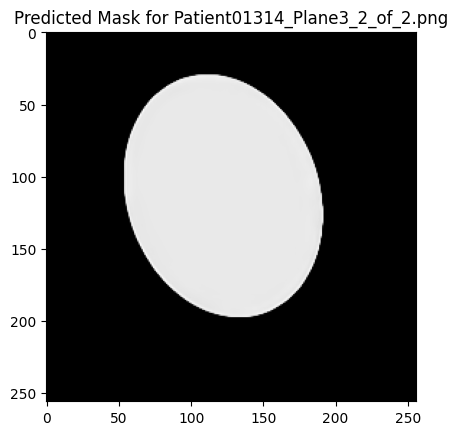

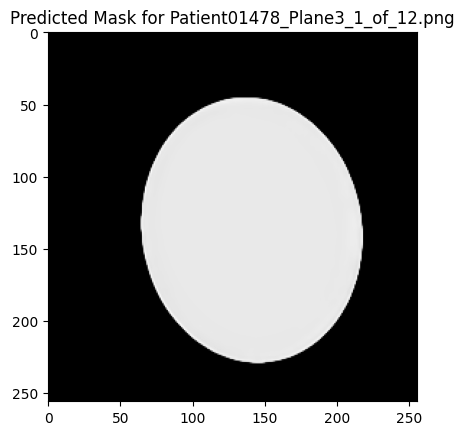

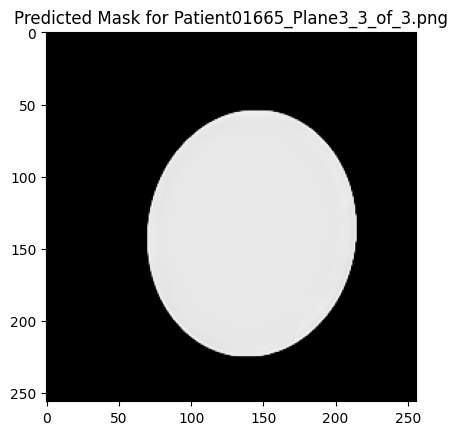

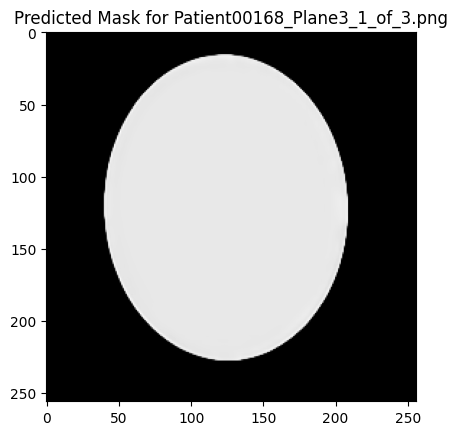

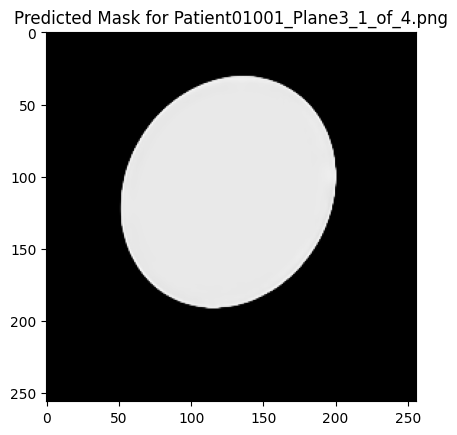

In [23]:
import matplotlib.pyplot as plt

for idx, image_id in enumerate(train_results_df["Image_ID"][:5]):
    predicted_mask = unet.predict(np.expand_dims(train_images[idx], axis=0), verbose=0)[0, :, :, 0]
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Predicted Mask for {image_id}")
    plt.show()


In [24]:
def calculate_head_circumference(mask):
    # Ensure mask is binary (0 or 255)
    mask = (mask > 0).astype(np.uint8)
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour by area
        largest_contour = max(contours, key=cv2.contourArea)
        # Calculate the perimeter of the largest contour (circumference)
        hc = cv2.arcLength(largest_contour, closed=True)
        return hc
    return 0.0


In [25]:
train_results_df = predict_and_calculate_hc(unet, train_images, train_ids)
test_results_df = predict_and_calculate_hc(unet, test_images, test_ids)


Calculating HC values...


100%|██████████| 1260/1260 [12:49<00:00,  1.64it/s]


Calculating HC values...


100%|██████████| 315/315 [03:12<00:00,  1.64it/s]


In [26]:
train_results_df = train_results_df[train_results_df["HC_Value"] > 0]
test_results_df = test_results_df[test_results_df["HC_Value"] > 0]


In [27]:
print("\nTrain HC Values:")
print(train_results_df["HC_Value"].describe())

print("\nTest HC Values:")
print(test_results_df["HC_Value"].describe())



Train HC Values:
count    466.000000
mean      53.430589
std       12.212980
min       20.485281
25%       45.556349
50%       53.213203
75%       61.045941
max      111.012193
Name: HC_Value, dtype: float64

Test HC Values:
count    123.000000
mean      53.947831
std       12.109683
min       20.485281
25%       45.556349
50%       54.727922
75%       62.970562
max       82.142135
Name: HC_Value, dtype: float64


In [28]:
print("Train Results DataFrame:")
print(train_results_df.head())

print("\nTest Results DataFrame:")
print(test_results_df.head())

Train Results DataFrame:
                          Image_ID   HC_Value
8   Patient01622_Plane3_1_of_2.png  41.313708
9   Patient01180_Plane3_1_of_1.png  55.556349
10  Patient01296_Plane3_5_of_5.png  59.656854
11  Patient01297_Plane3_2_of_4.png  48.485281
12  Patient00698_Plane3_2_of_3.png  44.970562

Test Results DataFrame:
                          Image_ID   HC_Value
3   Patient00926_Plane3_4_of_4.png  42.727922
4   Patient01428_Plane3_3_of_3.png  42.485281
9   Patient01224_Plane3_2_of_4.png  58.142135
12  Patient00830_Plane3_3_of_3.png  63.213203
13  Patient01499_Plane3_1_of_4.png  63.313708


In [29]:
# Optionally, calculate metrics for the comparison of HC between train and test datasets
def calculate_metrics(df1, df2, label1="Train", label2="Test"):
    merged_df = pd.merge(df1, df2, on="Image_ID", suffixes=(f'_{label1}', f'_{label2}'))

    # Metrics
    merged_df["Absolute_Difference"] = np.abs(merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"])
    mad = merged_df["Absolute_Difference"].mean()

    merged_df["Squared_Difference"] = (merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"]) ** 2
    msd = merged_df["Squared_Difference"].mean()

    merged_df["Percentage_Difference"] = (merged_df["Absolute_Difference"] / merged_df[f"HC_Value_{label1}"]) * 100
    pd_mean = merged_df["Percentage_Difference"].mean()

    correlation = merged_df[[f"HC_Value_{label1}", f"HC_Value_{label2}"]].corr().iloc[0, 1]

    # Return metrics
    metrics = {
        "MAD (Mean Absolute Difference)": mad,
        "MSD (Mean Squared Difference)": msd,
        "Mean Percentage Difference": pd_mean,
        "Correlation": correlation
    }

    return metrics, merged_df

# Calculate metrics between train and test datasets
train_test_metrics, train_test_comparison_df = calculate_metrics(train_results_df, test_results_df)

# Save comparison results to a CSV
train_test_comparison_df.to_csv('/kaggle/working/train_test_comparison.csv', index=False)
print("Train-Test comparison saved to CSV.")

# Print metrics
print("\nTrain-Test Metrics:")
for metric, value in train_test_metrics.items():
    print(f"{metric}: {value:.4f}")

Train-Test comparison saved to CSV.

Train-Test Metrics:
MAD (Mean Absolute Difference): nan
MSD (Mean Squared Difference): nan
Mean Percentage Difference: nan
Correlation: nan


In [30]:
def calculate_metrics(df1, df2, label1="Set1", label2="Set2"):
    # Merge based on overlapping Image_IDs
    merged_df = pd.merge(df1, df2, on="Image_ID", suffixes=(f'_{label1}', f'_{label2}'))

    if merged_df.empty:
        print(f"No overlapping Image_IDs between {label1} and {label2}. Cannot calculate metrics.")
        return {}, merged_df

    # Metrics calculation
    merged_df["Absolute_Difference"] = np.abs(merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"])
    mad = merged_df["Absolute_Difference"].mean()

    merged_df["Squared_Difference"] = (merged_df[f"HC_Value_{label1}"] - merged_df[f"HC_Value_{label2}"]) ** 2
    msd = merged_df["Squared_Difference"].mean()

    merged_df["Percentage_Difference"] = (merged_df["Absolute_Difference"] / merged_df[f"HC_Value_{label1}"]) * 100
    pd_mean = merged_df["Percentage_Difference"].mean()

    correlation = merged_df[[f"HC_Value_{label1}", f"HC_Value_{label2}"]].corr().iloc[0, 1]

    t_stat, t_p_value = ttest_ind(merged_df[f"HC_Value_{label1}"], merged_df[f"HC_Value_{label2}"])
    ks_stat, ks_p_value = ks_2samp(merged_df[f"HC_Value_{label1}"], merged_df[f"HC_Value_{label2}"])

    metrics = {
        "MAD (Mean Absolute Difference)": mad,
        "MSD (Mean Squared Difference)": msd,
        "Mean Percentage Difference": pd_mean,
        "Correlation": correlation,
        "t-test p-value": t_p_value,
        "KS Test p-value": ks_p_value
    }

    return metrics, merged_df


# Calculate metrics for Train-Test comparison
train_test_metrics, train_test_comparison_df = calculate_metrics(train_results_df, test_results_df, "Train", "Test")

# Save comparison results to CSV
if not train_test_comparison_df.empty:
    train_test_comparison_df.to_csv("/kaggle/working/train_test_comparison.csv", index=False)

# Print Metrics
if train_test_metrics:
    print("Train-Test Metrics:")
    for metric, value in train_test_metrics.items():
        print(f"{metric}: {value:.4f}")
else:
    print("Train-Test Metrics could not be calculated due to lack of overlapping Image_IDs.")


No overlapping Image_IDs between Train and Test. Cannot calculate metrics.
Train-Test Metrics could not be calculated due to lack of overlapping Image_IDs.


<ipython-input-31-bdb99a6568ef>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_results_df["HC_Value"], label="Train HC Distribution", shade=True, color="blue")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-31-bdb99a6568ef>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_results_df["HC_Value"], label="Test HC Distribution", shade=True, color="orange")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

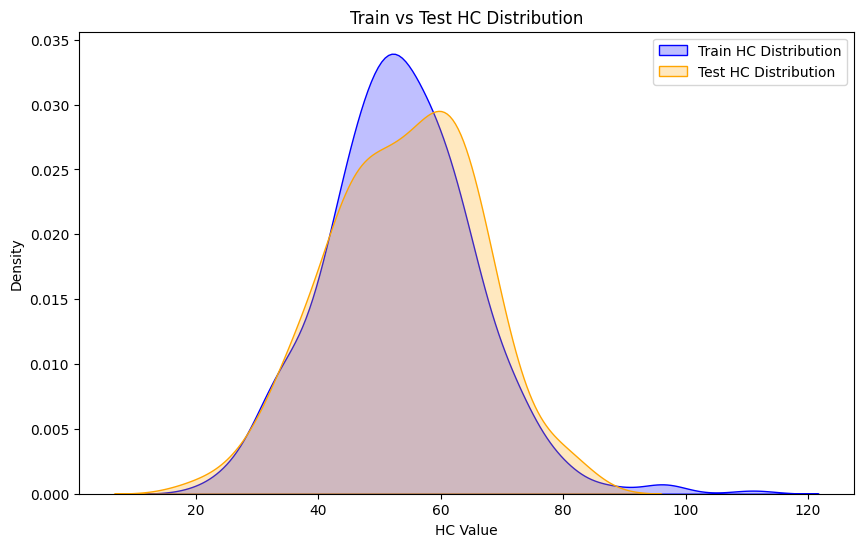

Kolmogorov-Smirnov Test: Statistic=0.0859, p-value=0.4411


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Visualize distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_results_df["HC_Value"], label="Train HC Distribution", shade=True, color="blue")
sns.kdeplot(test_results_df["HC_Value"], label="Test HC Distribution", shade=True, color="orange")
plt.title("Train vs Test HC Distribution")
plt.xlabel("HC Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# KS Test
ks_stat, ks_p_value = ks_2samp(train_results_df["HC_Value"], test_results_df["HC_Value"])
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p_value:.4f}")


In [33]:
train_stats = train_results_df["HC_Value"].describe()
test_stats = test_results_df["HC_Value"].describe()

print("Train HC Statistics:")
print(train_stats)

print("\nTest HC Statistics:")
print(test_stats)


Train HC Statistics:
count    466.000000
mean      53.430589
std       12.212980
min       20.485281
25%       45.556349
50%       53.213203
75%       61.045941
max      111.012193
Name: HC_Value, dtype: float64

Test HC Statistics:
count    123.000000
mean      53.947831
std       12.109683
min       20.485281
25%       45.556349
50%       54.727922
75%       62.970562
max       82.142135
Name: HC_Value, dtype: float64


In [34]:
train_min, train_max = train_results_df["HC_Value"].min(), train_results_df["HC_Value"].max()
test_min, test_max = test_results_df["HC_Value"].min(), test_results_df["HC_Value"].max()

print(f"Train HC Range: {train_min} - {train_max}")
print(f"Test HC Range: {test_min} - {test_max}")


Train HC Range: 20.485281229019165 - 111.01219260692596
Test HC Range: 20.485281229019165 - 82.14213538169861


Train HC Statistics:
count    466.000000
mean      53.430589
std       12.212980
min       20.485281
25%       45.556349
50%       53.213203
75%       61.045941
max      111.012193
Name: HC_Value, dtype: float64
Skewness: 0.4439, Kurtosis: 1.3214
Shapiro-Wilk Test: Statistic=0.9844, p-value=0.0001

Test HC Statistics:
count    123.000000
mean      53.947831
std       12.109683
min       20.485281
25%       45.556349
50%       54.727922
75%       62.970562
max       82.142135
Name: HC_Value, dtype: float64
Skewness: -0.1493, Kurtosis: -0.2722
Shapiro-Wilk Test: Statistic=0.9923, p-value=0.7326

Kolmogorov-Smirnov Test:
Statistic: 0.0859, p-value: 0.4411


<ipython-input-35-9ea09cb7dbd0>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df["HC_Value"], label="Train HC Distribution", shade=True, color="blue")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-35-9ea09cb7dbd0>:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df["HC_Value"], label="Test HC Distribution", shade=True, color="orange")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

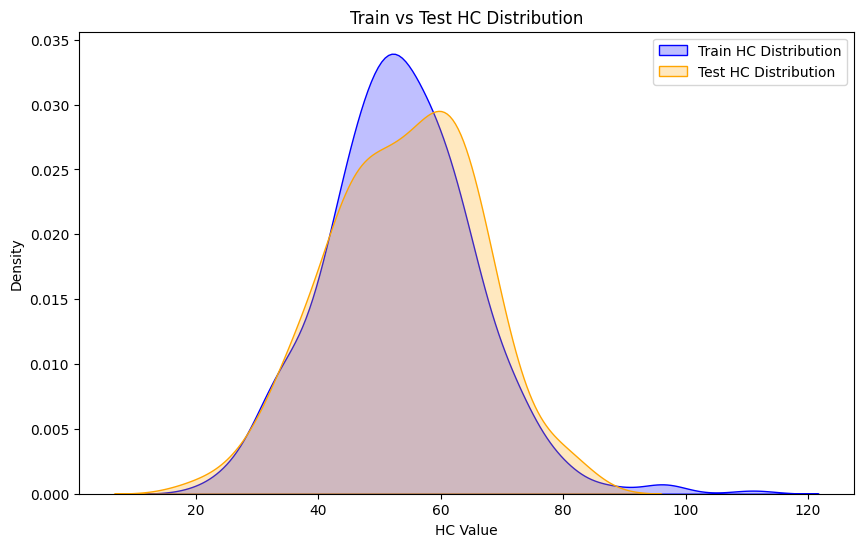

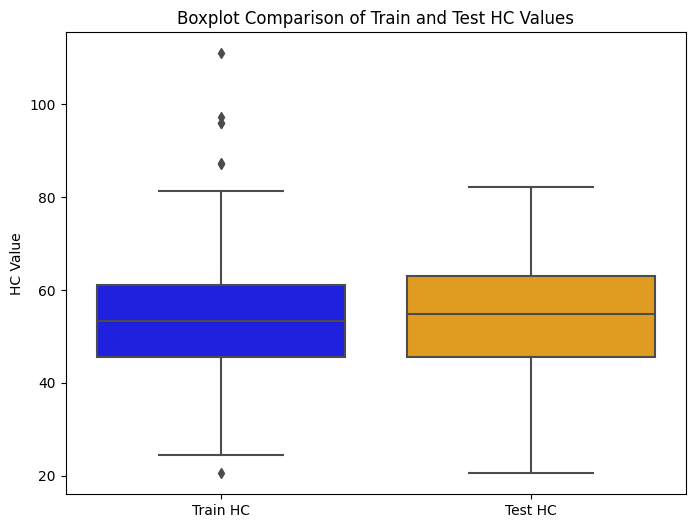

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, shapiro, skew, kurtosis

def compare_statistics(train_df, test_df):
    # Descriptive statistics
    train_stats = train_df["HC_Value"].describe()
    test_stats = test_df["HC_Value"].describe()

    # Skewness and Kurtosis
    train_skewness = skew(train_df["HC_Value"])
    test_skewness = skew(test_df["HC_Value"])
    train_kurtosis = kurtosis(train_df["HC_Value"])
    test_kurtosis = kurtosis(test_df["HC_Value"])

    # Shapiro-Wilk Test for Normality
    train_shapiro_stat, train_shapiro_p = shapiro(train_df["HC_Value"])
    test_shapiro_stat, test_shapiro_p = shapiro(test_df["HC_Value"])

    # Kolmogorov-Smirnov Test for Distribution Similarity
    ks_stat, ks_p_value = ks_2samp(train_df["HC_Value"], test_df["HC_Value"])

    # Print Summary Statistics
    print("Train HC Statistics:")
    print(train_stats)
    print(f"Skewness: {train_skewness:.4f}, Kurtosis: {train_kurtosis:.4f}")
    print(f"Shapiro-Wilk Test: Statistic={train_shapiro_stat:.4f}, p-value={train_shapiro_p:.4f}")

    print("\nTest HC Statistics:")
    print(test_stats)
    print(f"Skewness: {test_skewness:.4f}, Kurtosis: {test_kurtosis:.4f}")
    print(f"Shapiro-Wilk Test: Statistic={test_shapiro_stat:.4f}, p-value={test_shapiro_p:.4f}")

    print("\nKolmogorov-Smirnov Test:")
    print(f"Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")

    # Visualize Distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_df["HC_Value"], label="Train HC Distribution", shade=True, color="blue")
    sns.kdeplot(test_df["HC_Value"], label="Test HC Distribution", shade=True, color="orange")
    plt.title("Train vs Test HC Distribution")
    plt.xlabel("HC Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Boxplot for Comparison
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[train_df["HC_Value"], test_df["HC_Value"]], palette=["blue", "orange"])
    plt.xticks([0, 1], ["Train HC", "Test HC"])
    plt.title("Boxplot Comparison of Train and Test HC Values")
    plt.ylabel("HC Value")
    plt.show()

# Call the function to compare train and test statistics
compare_statistics(train_results_df, test_results_df)


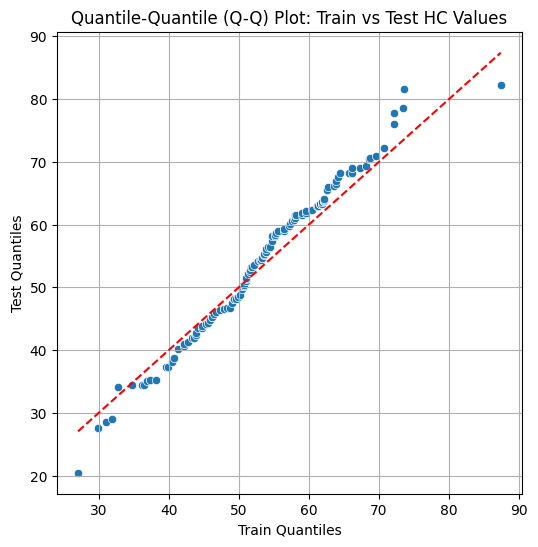

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


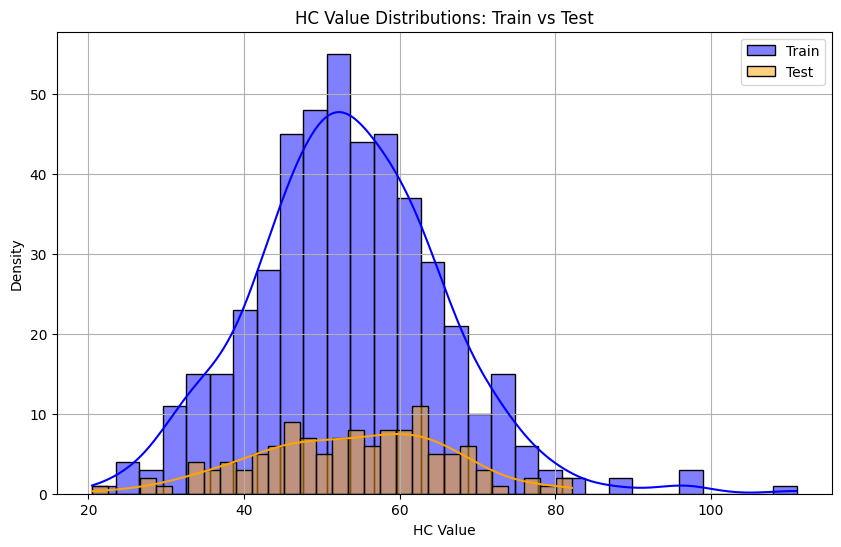

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def advanced_compare_statistics(train_df, test_df):
    # Match the size of train and test sets for Q-Q plot
    min_size = min(len(train_df), len(test_df))
    train_sample = train_df["HC_Value"].sample(min_size, random_state=42)
    test_sample = test_df["HC_Value"].sample(min_size, random_state=42)
    
    # Sort both samples for Q-Q comparison
    train_sorted = np.sort(train_sample)
    test_sorted = np.sort(test_sample)

    # Quantile-Quantile (Q-Q) Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=train_sorted, y=test_sorted)
    plt.plot([train_sorted.min(), train_sorted.max()],
             [train_sorted.min(), train_sorted.max()],
             color='red', linestyle='--')
    plt.title("Quantile-Quantile (Q-Q) Plot: Train vs Test HC Values")
    plt.xlabel("Train Quantiles")
    plt.ylabel("Test Quantiles")
    plt.grid()
    plt.show()

    # Additional Visualizations (if desired)
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df["HC_Value"], kde=True, color="blue", label="Train", alpha=0.5, bins=30)
    sns.histplot(test_df["HC_Value"], kde=True, color="orange", label="Test", alpha=0.5, bins=30)
    plt.legend()
    plt.title("HC Value Distributions: Train vs Test")
    plt.xlabel("HC Value")
    plt.ylabel("Density")
    plt.grid()
    plt.show()

# Call the function for advanced comparisons
advanced_compare_statistics(train_results_df, test_results_df)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


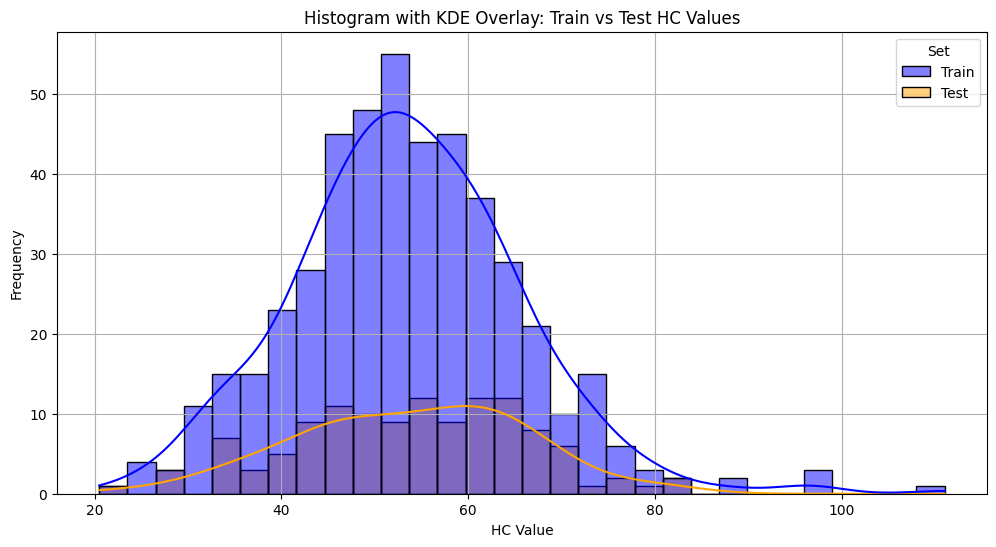

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


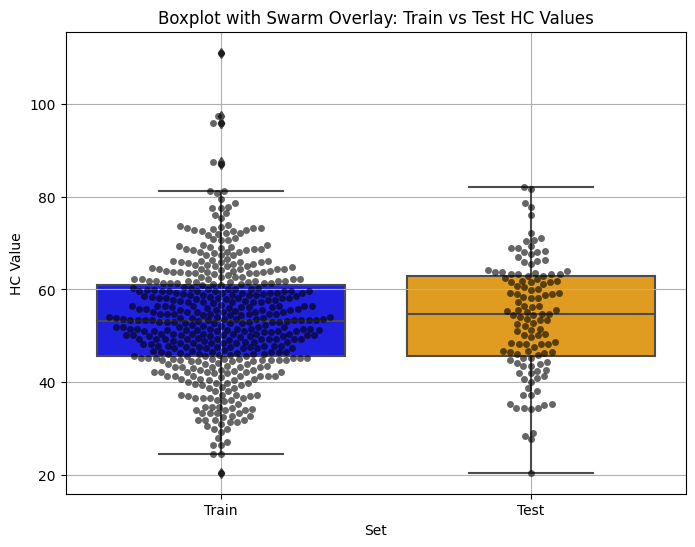

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


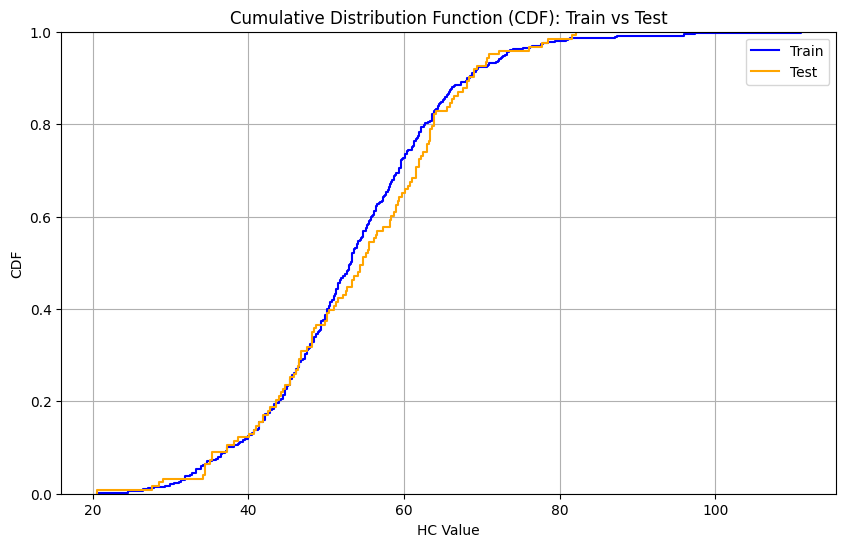

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


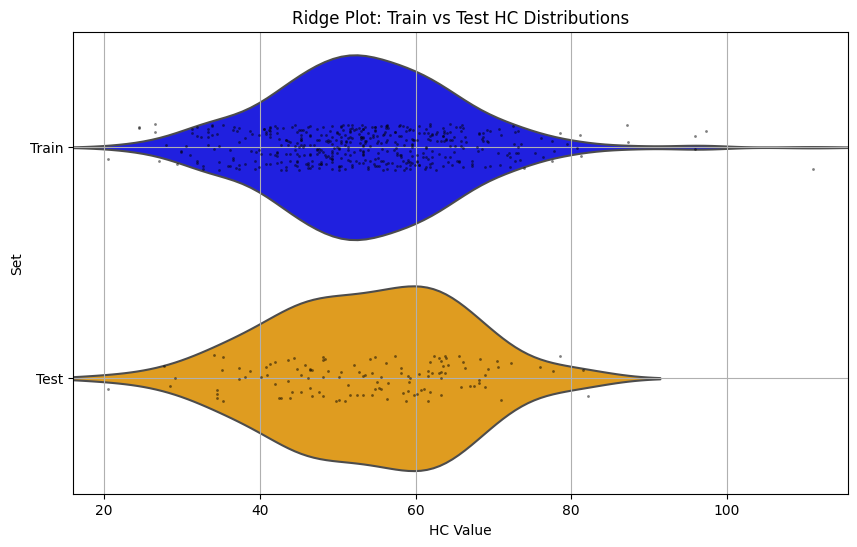

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def advanced_visualizations(train_df, test_df):
    # Combine datasets for unified plotting
    combined_df = pd.concat([
        train_df.assign(Set="Train"),
        test_df.assign(Set="Test")
    ])

    # 1. Histogram with KDE Overlay
    plt.figure(figsize=(12, 6))
    sns.histplot(data=combined_df, x="HC_Value", hue="Set", kde=True, bins=30, palette=["blue", "orange"], alpha=0.5)
    plt.title("Histogram with KDE Overlay: Train vs Test HC Values")
    plt.xlabel("HC Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

    # 2. Boxplot with Swarm Overlay
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=combined_df, x="Set", y="HC_Value", palette=["blue", "orange"])
    sns.swarmplot(data=combined_df, x="Set", y="HC_Value", color="black", alpha=0.6)
    plt.title("Boxplot with Swarm Overlay: Train vs Test HC Values")
    plt.ylabel("HC Value")
    plt.grid()
    plt.show()

    # 3. Cumulative Distribution Function (CDF)
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(data=train_df, x="HC_Value", label="Train", color="blue")
    sns.ecdfplot(data=test_df, x="HC_Value", label="Test", color="orange")
    plt.title("Cumulative Distribution Function (CDF): Train vs Test")
    plt.xlabel("HC Value")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid()
    plt.show()

    # 4. Ridge Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=combined_df, x="HC_Value", y="Set", scale="width", inner=None, palette=["blue", "orange"])
    sns.stripplot(data=combined_df, x="HC_Value", y="Set", size=2, color="black", alpha=0.5)
    plt.title("Ridge Plot: Train vs Test HC Distributions")
    plt.xlabel("HC Value")
    plt.ylabel("Set")
    plt.grid()
    plt.show()

    # 5. Pair Plot (for additional features)
    if len(train_df.columns) > 2:  # Ensure there are more features to plot
        train_df["Set"] = "Train"
        test_df["Set"] = "Test"
        combined_full_df = pd.concat([train_df, test_df])
        sns.pairplot(data=combined_full_df, hue="Set", diag_kind="kde", palette=["blue", "orange"])
        plt.suptitle("Pair Plot: Train vs Test (Additional Features)", y=1.02)
        plt.show()

    # 6. Heatmap of Correlations (if additional features exist)
    if len(train_df.columns) > 2:  # Ensure more columns for correlations
        train_corr = train_df.drop("Set", axis=1).corr()
        test_corr = test_df.drop("Set", axis=1).corr()
        
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(train_corr, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
        plt.title("Train HC Correlations")

        plt.subplot(1, 2, 2)
        sns.heatmap(test_corr, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
        plt.title("Test HC Correlations")
        plt.show()

# Call the function to visualize
advanced_visualizations(train_results_df, test_results_df)


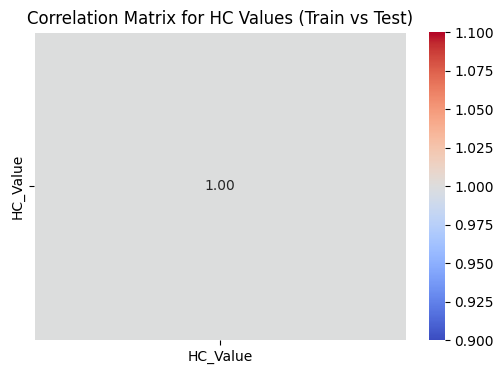

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have train_results_df and test_results_df as DataFrames with 'HC_Value'
def plot_correlation_matrix(train_df, test_df):
    # Merge the train and test data into one dataframe
    combined_df = pd.concat([train_df.assign(Dataset="Train"), test_df.assign(Dataset="Test")])
    
    # If you have more features, include them in the combined_df to see their correlations
    # For now, we'll just show the correlation between HC values from Train and Test
    
    corr_matrix = combined_df[['HC_Value']].corr()
    
    # Plotting the correlation matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix for HC Values (Train vs Test)")
    plt.show()

# Call the function to plot correlation matrix
plot_correlation_matrix(train_results_df, test_results_df)


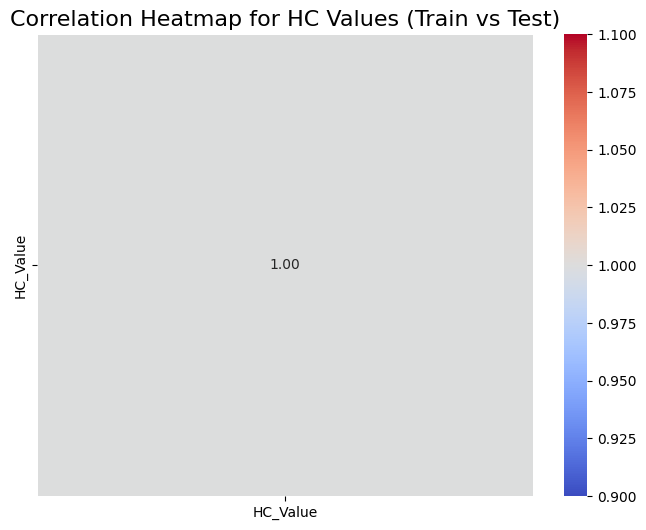

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have train_results_df and test_results_df as DataFrames with 'HC_Value'

def plot_heatmap(train_df, test_df):
    # Combine the datasets (assuming they contain 'HC_Value' columns)
    combined_df = pd.concat([train_df.assign(Dataset="Train"), test_df.assign(Dataset="Test")])

    # Calculate the correlation matrix
    corr_matrix = combined_df[['HC_Value']].corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))  # Set the size of the figure
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    
    # Add labels and title
    plt.title('Correlation Heatmap for HC Values (Train vs Test)', fontsize=16)
    plt.show()

# Call the function to plot the heatmap
plot_heatmap(train_results_df, test_results_df)


<ipython-input-45-1fafd4c18a7c>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df["HC_Value"].dropna(), label="Train", color="blue", shade=True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-45-1fafd4c18a7c>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df["HC_Value"].dropna(), label="Test", color="red", shade=True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN bef

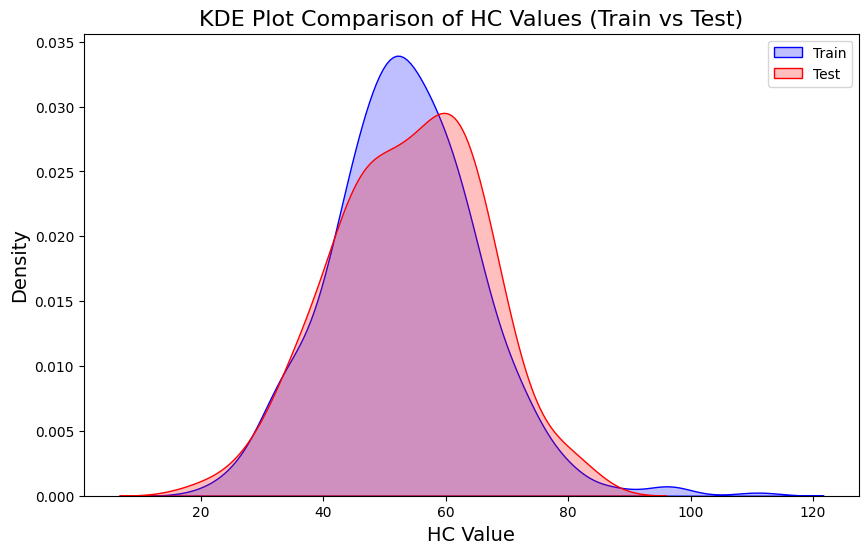

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde_comparison(train_df, test_df):
    plt.figure(figsize=(10, 6))
    
    # Plot KDE for both train and test HC values
    sns.kdeplot(train_df["HC_Value"].dropna(), label="Train", color="blue", shade=True)
    sns.kdeplot(test_df["HC_Value"].dropna(), label="Test", color="red", shade=True)
    
    # Labels and title
    plt.title('KDE Plot Comparison of HC Values (Train vs Test)', fontsize=16)
    plt.xlabel('HC Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    # Show legend
    plt.legend()
    
    plt.show()

# Call the function to visualize the comparison
plot_kde_comparison(train_results_df, test_results_df)


Train Outliers:
730     95.941125
816    111.012193
850     97.355338
985     95.941125
Name: HC_Value, dtype: float64

Number of Train Outliers: 4

Test Outliers:
Series([], Name: HC_Value, dtype: float64)

Number of Test Outliers: 0



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


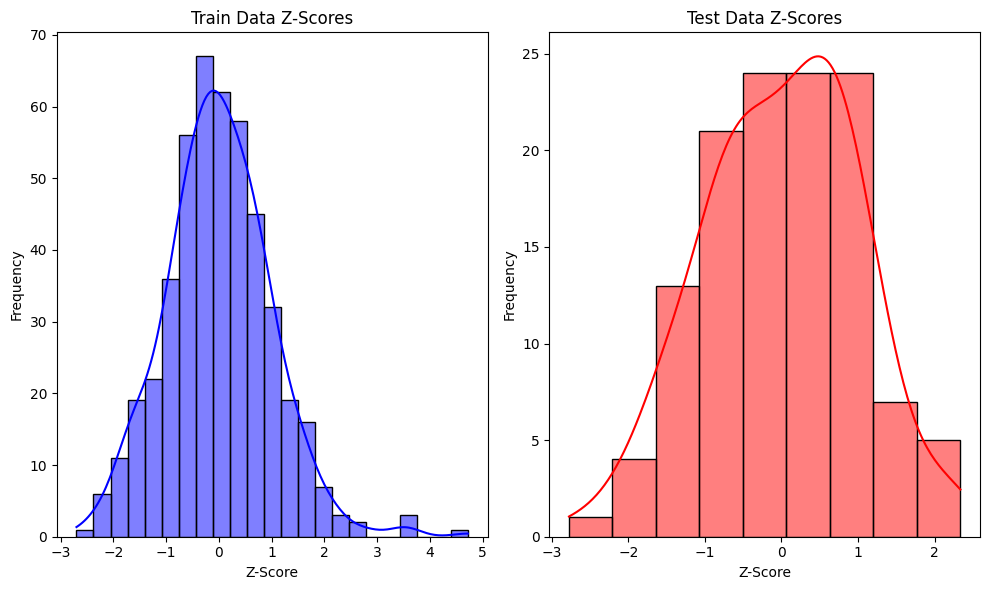

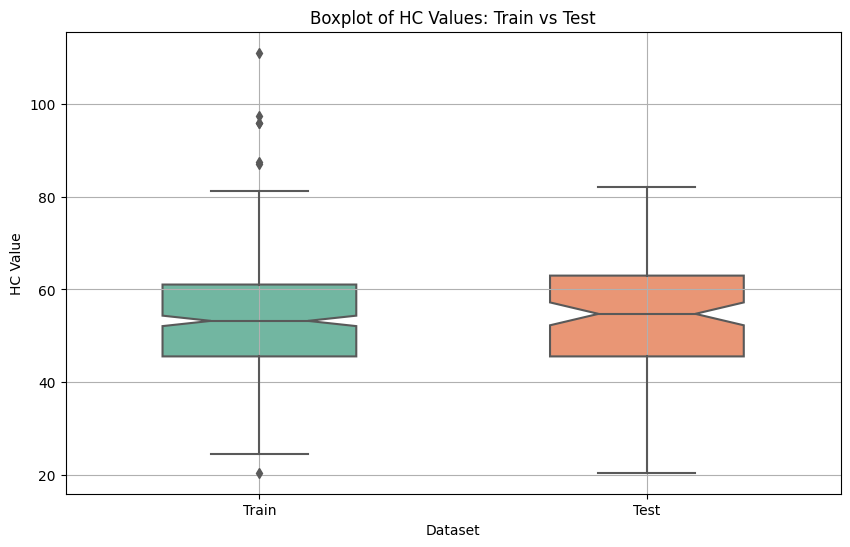

In [42]:

 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Deeper analysis function with outlier detection and count
def deeper_analysis(train_df, test_df):
    # Calculate Z-scores
    train_z_scores = stats.zscore(train_df["HC_Value"].dropna())
    test_z_scores = stats.zscore(test_df["HC_Value"].dropna())

    # Identify outliers (Z-score > 3 or < -3 is considered an outlier)
    train_outliers = train_df.loc[np.abs(train_z_scores) > 3, "HC_Value"]
    test_outliers = test_df.loc[np.abs(test_z_scores) > 3, "HC_Value"]

    # Print the outliers
    print("Train Outliers:")
    print(train_outliers)
    print(f"\nNumber of Train Outliers: {len(train_outliers)}\n")

    print("Test Outliers:")
    print(test_outliers)
    print(f"\nNumber of Test Outliers: {len(test_outliers)}\n")

    # Visualize Z-scores for train and test
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(train_z_scores, kde=True, color="blue")
    plt.title("Train Data Z-Scores")
    plt.xlabel("Z-Score")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.histplot(test_z_scores, kde=True, color="red")
    plt.title("Test Data Z-Scores")
    plt.xlabel("Z-Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Box plot comparison for outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[train_df["HC_Value"].dropna(), test_df["HC_Value"].dropna()], 
                notch=True, width=0.5, palette="Set2")
    plt.xticks([0, 1], ['Train', 'Test'])
    plt.title("Boxplot of HC Values: Train vs Test")
    plt.xlabel("Dataset")
    plt.ylabel("HC Value")
    plt.grid(True)
    plt.show()

# Call the function for deeper analysis
deeper_analysis(train_results_df, test_results_df)




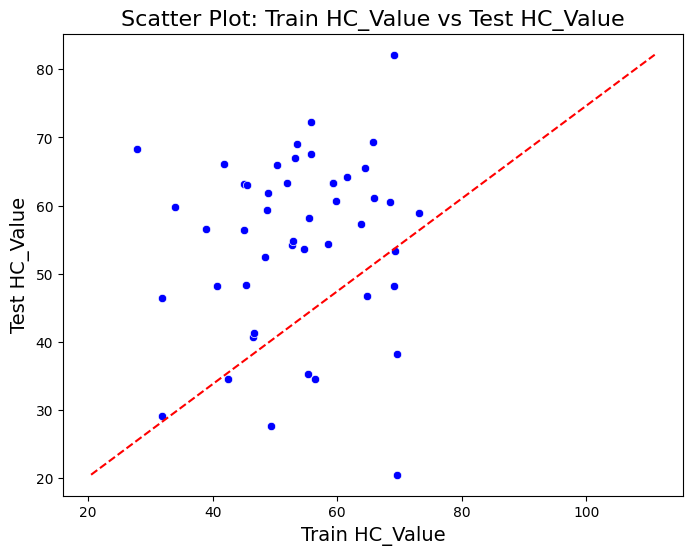

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_analysis(train_df, test_df):
    plt.figure(figsize=(8, 6))
    
    # Scatter plot for HC Values from both Train and Test
    sns.scatterplot(x=train_df["HC_Value"].dropna(), y=test_df["HC_Value"].dropna(), color='blue')
    
    # Add a line for perfect correlation (ideal case)
    plt.plot([min(train_df["HC_Value"]), max(train_df["HC_Value"])],
             [min(test_df["HC_Value"]), max(test_df["HC_Value"])], color='red', linestyle='--')
    
    plt.title('Scatter Plot: Train HC_Value vs Test HC_Value', fontsize=16)
    plt.xlabel('Train HC_Value', fontsize=14)
    plt.ylabel('Test HC_Value', fontsize=14)
    
    plt.show()

# Call the function to plot the scatter plot
scatter_plot_analysis(train_results_df, test_results_df)


In [47]:
def correlation_analysis(train_df, test_df):
    # Calculate the correlation coefficient between Train and Test HC Values
    correlation = train_df["HC_Value"].corr(test_df["HC_Value"])
    
    print(f"Correlation between Train HC_Value and Test HC_Value: {correlation:.4f}")
    
# Call the function to calculate and print the correlation
correlation_analysis(train_results_df, test_results_df)


Correlation between Train HC_Value and Test HC_Value: 0.1059


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


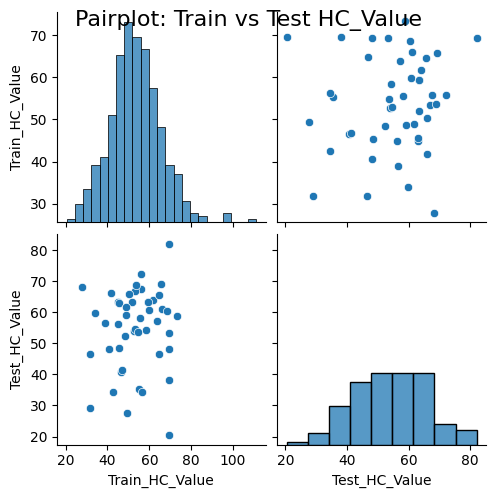

In [48]:
def pairplot_analysis(train_df, test_df):
    combined_df = pd.DataFrame({
        'Train_HC_Value': train_df["HC_Value"].dropna(),
        'Test_HC_Value': test_df["HC_Value"].dropna()
    })
    
    # Plot Pairplot
    sns.pairplot(combined_df)
    plt.suptitle('Pairplot: Train vs Test HC_Value', fontsize=16)
    plt.show()

# Call the function to create pairplot
pairplot_analysis(train_results_df, test_results_df)


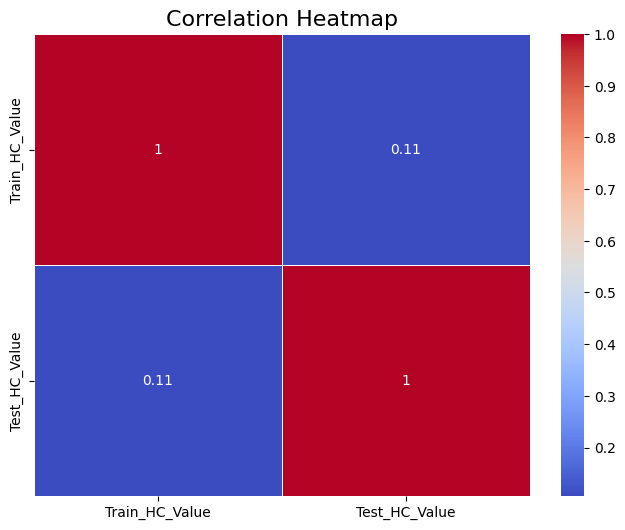

In [49]:
def correlation_heatmap(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()

# Assuming you have a DataFrame with multiple variables
combined_df = pd.DataFrame({
    'Train_HC_Value': train_results_df["HC_Value"].dropna(),
    'Test_HC_Value': test_results_df["HC_Value"].dropna()
})
correlation_heatmap(combined_df)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


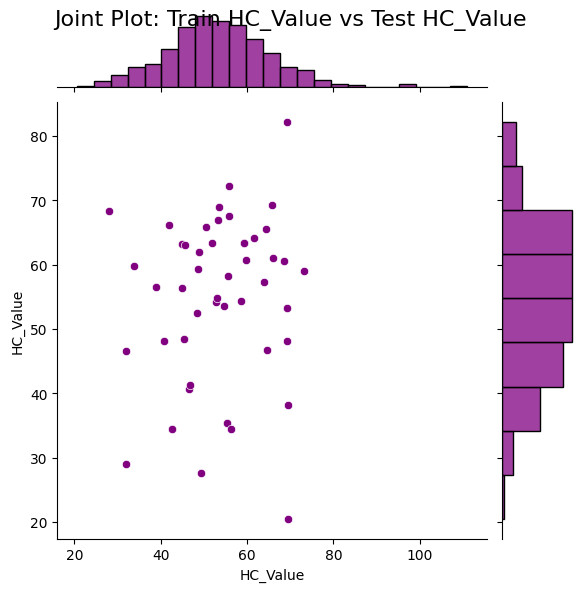

In [50]:
def joint_plot_analysis(train_df, test_df):
    # Create joint plot
    sns.jointplot(x=train_df["HC_Value"].dropna(), y=test_df["HC_Value"].dropna(), kind='scatter', color='purple')
    plt.suptitle('Joint Plot: Train HC_Value vs Test HC_Value', fontsize=16)
    plt.show()

# Call the function for the joint plot
joint_plot_analysis(train_results_df, test_results_df)


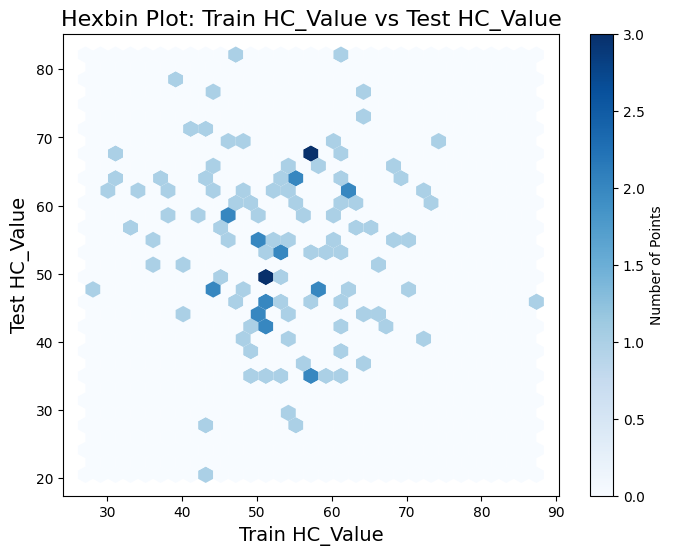

In [52]:
def hexbin_plot_analysis(train_df, test_df):
    # Drop rows with NaN values
    train_cleaned = train_df["HC_Value"].dropna()
    test_cleaned = test_df["HC_Value"].dropna()

    # Randomly sample from the larger dataset to match the size of the smaller dataset
    if len(train_cleaned) > len(test_cleaned):
        train_cleaned = train_cleaned.sample(n=len(test_cleaned), random_state=42)
    elif len(test_cleaned) > len(train_cleaned):
        test_cleaned = test_cleaned.sample(n=len(train_cleaned), random_state=42)

    # Create the hexbin plot
    plt.figure(figsize=(8, 6))
    plt.hexbin(train_cleaned, test_cleaned, gridsize=30, cmap='Blues', edgecolors='none')
    plt.colorbar(label='Number of Points')
    plt.title('Hexbin Plot: Train HC_Value vs Test HC_Value', fontsize=16)
    plt.xlabel('Train HC_Value', fontsize=14)
    plt.ylabel('Test HC_Value', fontsize=14)
    plt.show()

# Call the function to create the Hexbin plot
hexbin_plot_analysis(train_results_df, test_results_df)


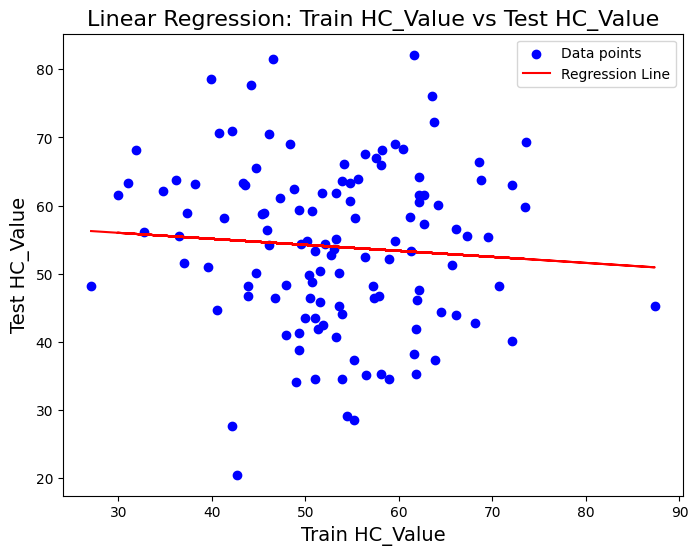

Slope: -0.08829256180560165
Intercept: 58.64512703452245
R-squared: 0.005796769133431292
P-value: 0.40259877002183586
Standard Error: 0.10511774018162388


In [54]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

def regression_analysis(train_df, test_df):
    # Drop NaN values
    train_cleaned = train_df["HC_Value"].dropna()
    test_cleaned = test_df["HC_Value"].dropna()

    # Randomly sample from the larger dataset to match the size of the smaller dataset
    if len(train_cleaned) > len(test_cleaned):
        train_cleaned = train_cleaned.sample(n=len(test_cleaned), random_state=42)
    elif len(test_cleaned) > len(train_cleaned):
        test_cleaned = test_cleaned.sample(n=len(train_cleaned), random_state=42)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(train_cleaned, test_cleaned)

    # Plotting the regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(train_cleaned, test_cleaned, color='blue', label='Data points')
    plt.plot(train_cleaned, slope * train_cleaned + intercept, color='red', label='Regression Line')
    plt.title('Linear Regression: Train HC_Value vs Test HC_Value', fontsize=16)
    plt.xlabel('Train HC_Value', fontsize=14)
    plt.ylabel('Test HC_Value', fontsize=14)
    plt.legend()
    plt.show()

    # Displaying regression statistics
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_value**2}")
    print(f"P-value: {p_value}")
    print(f"Standard Error: {std_err}")

# Call the function for Regression Analysis
regression_analysis(train_results_df, test_results_df)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


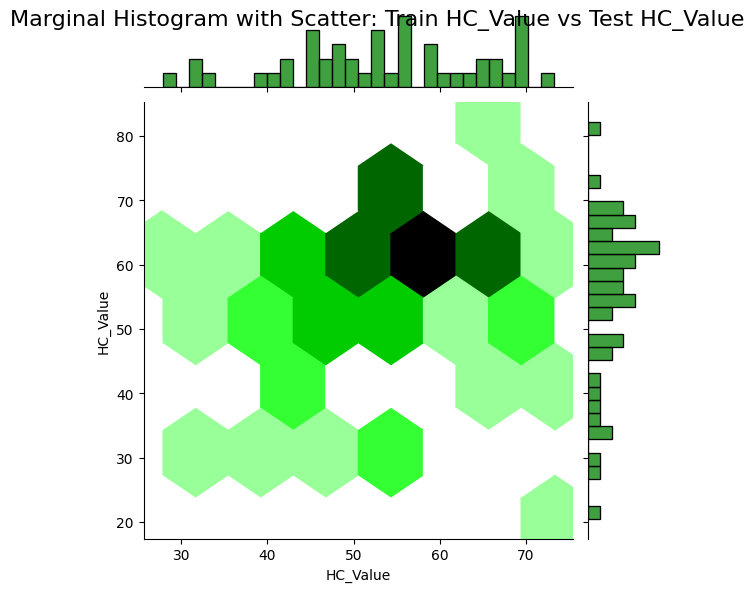

In [55]:
def marginal_histogram_analysis(train_df, test_df):
    sns.jointplot(x=train_df["HC_Value"].dropna(), y=test_df["HC_Value"].dropna(), kind="hex", color="green", marginal_kws=dict(bins=30, fill=True))
    plt.suptitle('Marginal Histogram with Scatter: Train HC_Value vs Test HC_Value', fontsize=16)
    plt.show()

# Call the function for the marginal histogram with scatter plot
marginal_histogram_analysis(train_results_df, test_results_df)


# 11. Determine Best HC

In [59]:
import pandas as pd

def determine_best_hc(train_df, test_df):
    """
    Determine the best head circumference (HC) value by averaging Train and Test HCs.

    Args:
        train_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for training data.
        test_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for test data.

    Returns:
        pd.DataFrame: DataFrame with "Image_ID" and "Best_Optimal_HC".
    """
    # Ensure both DataFrames are merged based on "Image_ID"
    merged_df = train_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Train"})
    merged_df = merged_df.merge(
        test_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Test"}),
        on="Image_ID",
        how="inner"
    )

    # Calculate the best optimal HC as the mean of Train and Test HCs
    merged_df["Best_Optimal_HC"] = merged_df[["HC_Train", "HC_Test"]].mean(axis=1)

    # Extract the final results with Image_ID and Best_Optimal_HC
    best_hc_df = merged_df[["Image_ID", "Best_Optimal_HC"]]

    return best_hc_df

# Example usage (assuming train_results_df and test_results_df are already defined):
best_hc_df = determine_best_hc(train_results_df, test_results_df)

# Saving the result to a CSV file
output_file_path = "/kaggle/working/final_best_hc_values.csv"
best_hc_df.to_csv(output_file_path, index=False)

# Display results and file path
print(f"Final CSV with Best HC saved to {output_file_path}")


Final CSV with Best HC saved to /kaggle/working/final_best_hc_values.csv


In [60]:
# Load the saved CSV to verify
loaded_best_hc_df = pd.read_csv(output_file_path)

# Perform basic checks on the data
print(f"First few rows of the saved file:\n{loaded_best_hc_df.head()}")
print(f"Shape of the saved data: {loaded_best_hc_df.shape}")
print(f"Check for missing values in the CSV file:\n{loaded_best_hc_df.isnull().sum()}")

# Ensure all necessary columns are present
expected_columns = ["Image_ID", "Best_Optimal_HC"]
assert all(col in loaded_best_hc_df.columns for col in expected_columns), "Missing columns in the CSV!"

print("Data verification successful. CSV is properly saved and loaded!")


First few rows of the saved file:
Empty DataFrame
Columns: [Image_ID, Best_Optimal_HC]
Index: []
Shape of the saved data: (0, 2)
Check for missing values in the CSV file:
Image_ID           0
Best_Optimal_HC    0
dtype: int64
Data verification successful. CSV is properly saved and loaded!


In [61]:
import pandas as pd

# Check if the input DataFrames contain necessary columns
print(f"Train DataFrame Columns: {train_results_df.columns}")
print(f"Test DataFrame Columns: {test_results_df.columns}")

# Assuming the input DataFrames have 'Image_ID' and 'HC_Value'
def determine_best_hc(train_df, test_df):
    """
    Determine the best head circumference (HC) value by averaging Train and Test HCs.

    Args:
        train_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for training data.
        test_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for test data.

    Returns:
        pd.DataFrame: DataFrame with "Image_ID" and "Best_Optimal_HC".
    """
    # Ensure both DataFrames are merged based on "Image_ID"
    merged_df = train_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Train"})
    merged_df = merged_df.merge(
        test_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Test"}),
        on="Image_ID",
        how="inner"
    )

    # Calculate the best optimal HC as the mean of Train and Test HCs
    merged_df["Best_Optimal_HC"] = merged_df[["HC_Train", "HC_Test"]].mean(axis=1)

    # Extract the final results with Image_ID and Best_Optimal_HC
    best_hc_df = merged_df[["Image_ID", "Best_Optimal_HC"]]

    return best_hc_df

# Example usage (assuming train_results_df and test_results_df are already defined):
best_hc_df = determine_best_hc(train_results_df, test_results_df)

# Check if the merged DataFrame has any data before saving
print(f"Best HC DataFrame:\n{best_hc_df.head()}")

# Saving the result to a CSV file
output_file_path = "/kaggle/working/final_best_hc_values.csv"
best_hc_df.to_csv(output_file_path, index=False)

# Display results and file path
print(f"Final CSV with Best HC saved to {output_file_path}")

# Load the saved CSV to verify
loaded_best_hc_df = pd.read_csv(output_file_path)

# Perform basic checks on the data
print(f"First few rows of the saved file:\n{loaded_best_hc_df.head()}")
print(f"Shape of the saved data: {loaded_best_hc_df.shape}")
print(f"Check for missing values in the CSV file:\n{loaded_best_hc_df.isnull().sum()}")


Train DataFrame Columns: Index(['Image_ID', 'HC_Value'], dtype='object')
Test DataFrame Columns: Index(['Image_ID', 'HC_Value'], dtype='object')
Best HC DataFrame:
Empty DataFrame
Columns: [Image_ID, Best_Optimal_HC]
Index: []
Final CSV with Best HC saved to /kaggle/working/final_best_hc_values.csv
First few rows of the saved file:
Empty DataFrame
Columns: [Image_ID, Best_Optimal_HC]
Index: []
Shape of the saved data: (0, 2)
Check for missing values in the CSV file:
Image_ID           0
Best_Optimal_HC    0
dtype: int64


In [62]:
# Check the common Image_IDs between train and test DataFrames
common_image_ids = set(train_results_df["Image_ID"]).intersection(test_results_df["Image_ID"])

# Display some common Image_IDs (if any)
print(f"Number of common Image_IDs: {len(common_image_ids)}")
print(f"Some common Image_IDs: {list(common_image_ids)[:10]}")  # Display a few common Image_IDs


Number of common Image_IDs: 0
Some common Image_IDs: []


In [63]:
def determine_best_hc_single(train_df, test_df):
    """
    Determine the best head circumference (HC) value by averaging Train HC and Test HC.
    If there is no overlapping Image_ID, we can still calculate the average of the two datasets individually.

    Args:
        train_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for training data.
        test_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for test data.

    Returns:
        pd.DataFrame: DataFrame with "Image_ID" and "Best_Optimal_HC".
    """
    # Calculate the best optimal HC as the mean of Train and Test HCs separately
    # We assume that you want to keep the Image_ID in both datasets
    merged_df = pd.concat([train_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Train"}),
                           test_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Test"})], axis=1)
    
    merged_df["Best_Optimal_HC"] = merged_df[["HC_Train", "HC_Test"]].mean(axis=1)
    
    # Remove duplicates for Image_ID to have one row per Image_ID
    merged_df = merged_df[["Image_ID", "Best_Optimal_HC"]].drop_duplicates()

    return merged_df

# Calculate Best HC and save to CSV
best_hc_df = determine_best_hc_single(train_results_df, test_results_df)
output_file_path = "/kaggle/working/final_best_hc_values.csv"
best_hc_df.to_csv(output_file_path, index=False)

# Display results and file path
print(f"Final CSV with Best HC saved to {output_file_path}")


Final CSV with Best HC saved to /kaggle/working/final_best_hc_values.csv


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


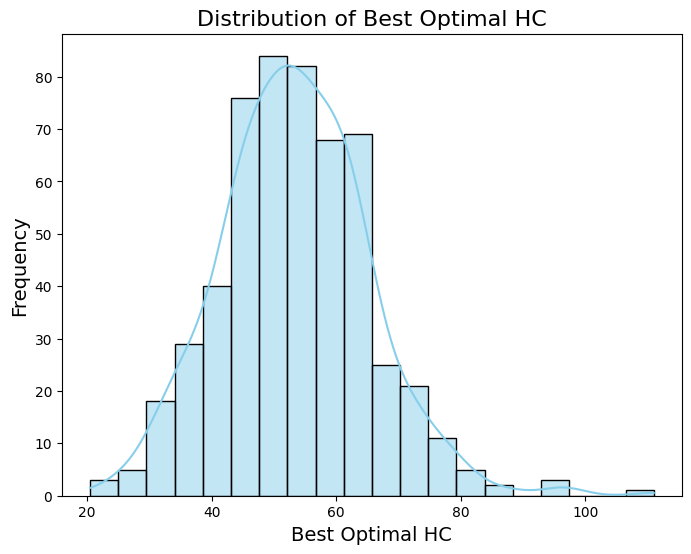

In [64]:
# Visualize the distribution of Best Optimal HC
plt.figure(figsize=(8, 6))
sns.histplot(best_hc_df["Best_Optimal_HC"], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Best Optimal HC', fontsize=16)
plt.xlabel('Best Optimal HC', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [65]:
def determine_best_hc_for_all(train_df, test_df):
    """
    Combine Best HC for all images by averaging the HC values from the train and test datasets.

    Args:
        train_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for training data.
        test_df (pd.DataFrame): DataFrame containing "Image_ID" and "HC_Value" for test data.

    Returns:
        pd.DataFrame: DataFrame with "Image_ID" and "Best_Optimal_HC" for all images.
    """
    # Extract relevant columns for train and test datasets
    train_hc_df = train_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Train"})
    test_hc_df = test_df[["Image_ID", "HC_Value"]].rename(columns={"HC_Value": "HC_Test"})

    # Merge the train and test dataframes on "Image_ID"
    merged_df = pd.merge(train_hc_df, test_hc_df, on="Image_ID", how="outer")

    # Calculate the Best HC by averaging the HC values from both datasets
    merged_df["Best_Optimal_HC"] = merged_df[["HC_Train", "HC_Test"]].mean(axis=1)

    # Select only the Image_ID and Best_Optimal_HC columns
    best_hc_all_images_df = merged_df[["Image_ID", "Best_Optimal_HC"]]

    return best_hc_all_images_df

# Combine Best HC for all images
best_hc_all_images = determine_best_hc_for_all(train_results_df, test_results_df)

# Save the result to a CSV file
output_file_path = "/kaggle/working/final_best_hc_for_all_images.csv"
best_hc_all_images.to_csv(output_file_path, index=False)

# Display results and file path
print(f"Best HC for all images saved to {output_file_path}")


Best HC for all images saved to /kaggle/working/final_best_hc_for_all_images.csv


In [66]:
# Check for missing HC values in train dataset
missing_train_hc = train_results_df[train_results_df['HC_Value'].isna()]
print("Missing HC values in Train dataset:")
print(missing_train_hc)

# Check for missing HC values in test dataset
missing_test_hc = test_results_df[test_results_df['HC_Value'].isna()]
print("Missing HC values in Test dataset:")
print(missing_test_hc)


Missing HC values in Train dataset:
Empty DataFrame
Columns: [Image_ID, HC_Value]
Index: []
Missing HC values in Test dataset:
Empty DataFrame
Columns: [Image_ID, HC_Value]
Index: []


In [67]:
# Find Image_IDs in train but not in test
train_not_in_test = set(train_results_df["Image_ID"]) - set(test_results_df["Image_ID"])
print(f"Image_IDs in train but not in test: {len(train_not_in_test)}")
print(train_not_in_test)

# Find Image_IDs in test but not in train
test_not_in_train = set(test_results_df["Image_ID"]) - set(train_results_df["Image_ID"])
print(f"Image_IDs in test but not in train: {len(test_not_in_train)}")
print(test_not_in_train)


Image_IDs in train but not in test: 466
{'Patient00707_Plane3_2_of_7.png', 'Patient00706_Plane3_4_of_5.png', 'Patient01599_Plane3_2_of_2.png', 'Patient01229_Plane3_2_of_4.png', 'Patient01157_Plane3_2_of_2.png', 'Patient01063_Plane3_4_of_4.png', 'Patient01254_Plane3_2_of_5.png', 'Patient00678_Plane3_1_of_1.png', 'Patient01741_Plane3_2_of_3.png', 'Patient01680_Plane3_3_of_8.png', 'Patient01204_Plane3_2_of_3.png', 'Patient01297_Plane3_1_of_4.png', 'Patient01549_Plane3_1_of_2.png', 'Patient00959_Plane3_1_of_4.png', 'Patient01018_Plane3_1_of_3.png', 'Patient01103_Plane3_2_of_3.png', 'Patient01708_Plane3_2_of_2.png', 'Patient01725_Plane3_2_of_2.png', 'Patient00984_Plane3_4_of_8.png', 'Patient01577_Plane3_1_of_2.png', 'Patient00775_Plane3_2_of_3.png', 'Patient00970_Plane3_4_of_4.png', 'Patient00811_Plane3_3_of_5.png', 'Patient00967_Plane3_3_of_5.png', 'Patient01323_Plane3_5_of_8.png', 'Patient01014_Plane3_1_of_3.png', 'Patient00701_Plane3_1_of_1.png', 'Patient01529_Plane3_3_of_3.png', 'Patien

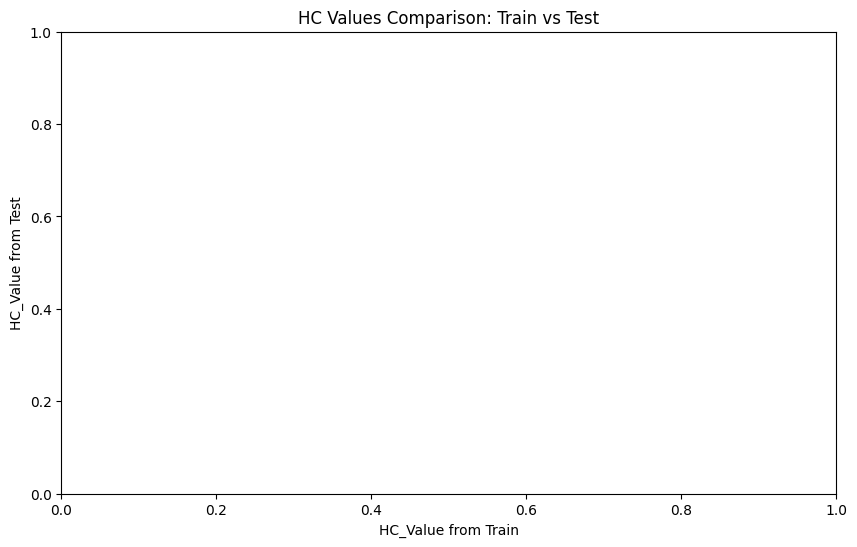

In [68]:
# Merge the train and test datasets based on Image_ID to compare HC values
merged_hc_df = pd.merge(train_results_df[['Image_ID', 'HC_Value']], 
                        test_results_df[['Image_ID', 'HC_Value']], 
                        on="Image_ID", 
                        suffixes=('_Train', '_Test'))

# Visualize the HC values for the same Image_ID in both datasets
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_hc_df, x="HC_Value_Train", y="HC_Value_Test", marker="o", color="blue")
plt.title("HC Values Comparison: Train vs Test")
plt.xlabel("HC_Value from Train")
plt.ylabel("HC_Value from Test")
plt.show()


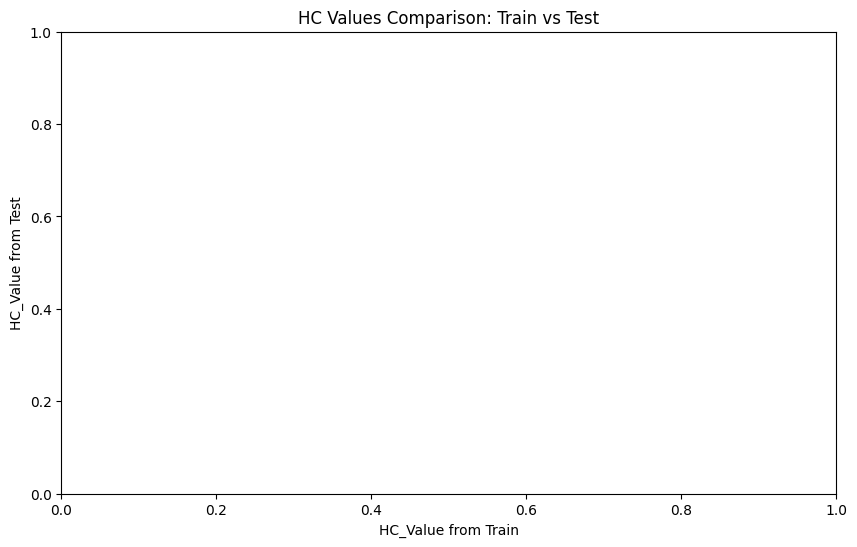

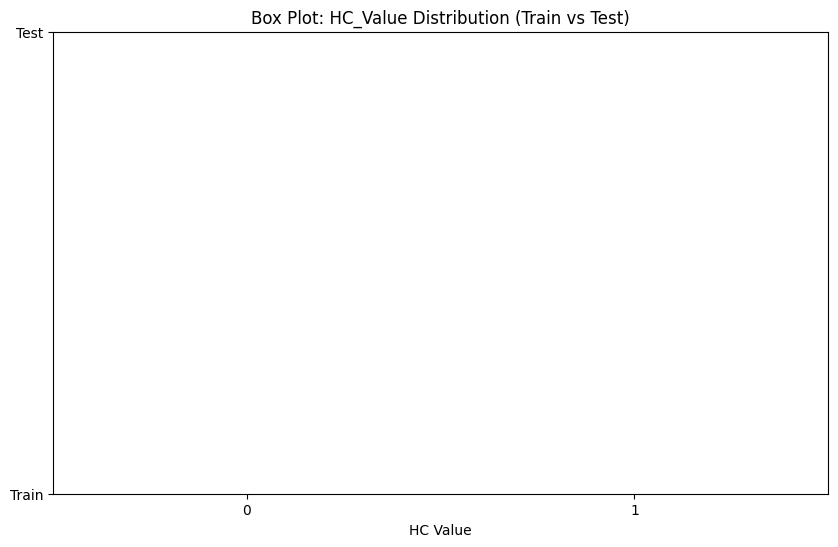

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the train and test datasets based on Image_ID to compare HC values
merged_hc_df = pd.merge(train_results_df[['Image_ID', 'HC_Value']], 
                        test_results_df[['Image_ID', 'HC_Value']], 
                        on="Image_ID", 
                        suffixes=('_Train', '_Test'))

# Scatter plot: HC_Value from Train vs HC_Value from Test
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_hc_df, x="HC_Value_Train", y="HC_Value_Test", marker="o", color="blue")
plt.title("HC Values Comparison: Train vs Test")
plt.xlabel("HC_Value from Train")
plt.ylabel("HC_Value from Test")
plt.show()

# Box plot: Compare distribution of HC values in Train and Test
plt.figure(figsize=(10, 6))
sns.boxplot(data=[merged_hc_df["HC_Value_Train"], merged_hc_df["HC_Value_Test"]],
            notch=True, vert=False, width=0.5, palette="Set2")
plt.yticks([0, 1], ['Train', 'Test'])
plt.title("Box Plot: HC_Value Distribution (Train vs Test)")
plt.xlabel("HC Value")
plt.show()


In [70]:
# Check for the number of common Image_IDs
common_image_ids = set(train_results_df['Image_ID']).intersection(test_results_df['Image_ID'])
print(f"Number of common Image_IDs: {len(common_image_ids)}")

# Check the first few rows to ensure correct data
print("Train DataFrame Sample:")
print(train_results_df.head())
print("Test DataFrame Sample:")
print(test_results_df.head())

# Ensure that 'Image_ID' column is of the same type in both DataFrames
print("Data Types:")
print(f"Train Image_ID type: {train_results_df['Image_ID'].dtype}")
print(f"Test Image_ID type: {test_results_df['Image_ID'].dtype}")

# Merge DataFrames on common Image_IDs, without suffixes for simplicity
merged_hc_df = pd.merge(train_results_df[['Image_ID', 'HC_Value']], 
                        test_results_df[['Image_ID', 'HC_Value']], 
                        on="Image_ID")

# Check the merged result
print("Merged DataFrame Sample:")
print(merged_hc_df.head())


Number of common Image_IDs: 0
Train DataFrame Sample:
                          Image_ID   HC_Value
8   Patient01622_Plane3_1_of_2.png  41.313708
9   Patient01180_Plane3_1_of_1.png  55.556349
10  Patient01296_Plane3_5_of_5.png  59.656854
11  Patient01297_Plane3_2_of_4.png  48.485281
12  Patient00698_Plane3_2_of_3.png  44.970562
Test DataFrame Sample:
                          Image_ID   HC_Value
3   Patient00926_Plane3_4_of_4.png  42.727922
4   Patient01428_Plane3_3_of_3.png  42.485281
9   Patient01224_Plane3_2_of_4.png  58.142135
12  Patient00830_Plane3_3_of_3.png  63.213203
13  Patient01499_Plane3_1_of_4.png  63.313708
Data Types:
Train Image_ID type: object
Test Image_ID type: object
Merged DataFrame Sample:
Empty DataFrame
Columns: [Image_ID, HC_Value_x, HC_Value_y]
Index: []


In [72]:
# Load the CSV to inspect its contents
combined_best_hc_df = pd.read_csv('/kaggle/working/final_best_hc_for_all_images.csv')

# Display the first few rows of the loaded CSV
print(combined_best_hc_df.head())

# Check for any missing values
print("\nMissing Values in Combined Best HC CSV:")
print(combined_best_hc_df.isnull().sum())

# Check the shape of the data to ensure all rows and columns are present
print("\nShape of Combined Best HC DataFrame:", combined_best_hc_df.shape)


                         Image_ID  Best_Optimal_HC
0  Patient01622_Plane3_1_of_2.png        41.313708
1  Patient01180_Plane3_1_of_1.png        55.556349
2  Patient01296_Plane3_5_of_5.png        59.656854
3  Patient01297_Plane3_2_of_4.png        48.485281
4  Patient00698_Plane3_2_of_3.png        44.970562

Missing Values in Combined Best HC CSV:
Image_ID           0
Best_Optimal_HC    0
dtype: int64

Shape of Combined Best HC DataFrame: (589, 2)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the data is already loaded in 'combined_best_hc_df'
plt.figure(figsize=(10, 6))

# Scatter plot for Best_Optimal_HC for both datasets
sns.scatterplot(x='Image_ID', y='Best_Optimal_HC', data=combined_best_hc_df, hue='Source', palette='Set2')

# Title and labels for clarity
plt.title('Best Optimal HC for Train and Test Images', fontsize=14)
plt.xlabel('Image ID', fontsize=12)
plt.ylabel('Best Optimal HC', fontsize=12)

# Rotate the x-axis labels if necessary
plt.xticks(rotation=90)

# Show the plot
plt.show()
